# all imports

In [1]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#Uncomment to predict real data
keep_parts = slice(5)

epochs = 10000 # ctrl-c to stop early
lr = 0.001

seq_len = 50
batch_size = 2

# Increase hidden_dim depending on number of parts being trained
# since it encodes forecast for all parts
hidden_dim = 512
layers = 2

# How far into the future to plot at the end
predict_steps = 24
predict_start = 0
predict_end = -predict_steps

array = pd.read_csv("order-data.csv", skiprows=[0]).to_numpy()[keep_parts]

# making sin wave

In [4]:
# # Test Sin wave to make sure everything is working...
# epochs = 10000
# lr = .001
# seq_len = 150
# batch_size = 1
# hidden_dim = 128
# layers = 2
# predict_steps = 100
# predict_start = -seq_len
# predict_end = None
# array = np.array([[f'Wave {i}']+[np.sin(x + i*2*np.pi/2)*(i+1) for x in np.linspace(-1000, 1000, 10051)] for i in range(2)])

# transose the array and normalize the data

In [5]:
parts = array.T[0]
floats = np.array(array.T[1:], dtype='float32')

min_ = floats.min(0)
max_ = floats.max(0)
floats = (floats - min_) / (max_ - min_)

tensor = torch.from_numpy(floats)

# batching of data from my array

In [6]:
def batch_data(items, seq_len, batch_size):
    num_batches = (len(items)-1) // (seq_len * batch_size)
    keep = num_batches*seq_len*batch_size
    discard = len(items) - keep - 1
    if discard: print(f"Discarding last {discard} items")
    features = items[:keep]   .view(batch_size, num_batches, seq_len, -1).transpose(0,1).transpose(1,2).to(device)
    targets  = items[1:keep+1].view(batch_size, num_batches, seq_len, -1).transpose(0,1).transpose(1,2).to(device)
    return [*zip(features, targets)]

In [7]:
# split = int(tensor.shape[0] * .8)
# train = batch_data(tensor[:split], seq_len, batch_size)
# valid = batch_data(tensor[split:], seq_len, batch_size)
train = valid = batch_data(tensor, seq_len, batch_size)

Discarding last 3 items


# creating my RNN model. using GRU because it is faster

In [8]:
class RNN(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layers, dropout=.3)
        self.fc = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(.3)

    def forward(self, x, hidden):
        y, hidden = self.lstm(x, hidden)
        y = y.view(-1, hidden_dim)
        y = self.dropout(y)
        y = self.fc(y)
        return y.view(x.shape), hidden

# define loss and optimizer

In [9]:
model = RNN(tensor.shape[-1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    hidden = None
    for x, target in train:
        if hidden:
            hidden = tuple(h.detach() for h in hidden)

        y, hidden = model(x, hidden)
        loss = criterion(y, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        hidden = None
        for x, target in valid:
            y, hidden = model(x, hidden)
            loss = criterion(y, target)
            valid_loss += loss.item()

    print(f"Epoc {epoch}",
          f"train_loss={round(train_loss*1e5/len(train))}",
          f"valid_loss={round(valid_loss*1e5/len(valid))}")

Epoc 0 train_loss=1880 valid_loss=1443
Epoc 1 train_loss=1440 valid_loss=1593
Epoc 2 train_loss=1614 valid_loss=1459
Epoc 3 train_loss=1447 valid_loss=1420
Epoc 4 train_loss=1432 valid_loss=1437
Epoc 5 train_loss=1444 valid_loss=1453
Epoc 6 train_loss=1446 valid_loss=1449
Epoc 7 train_loss=1458 valid_loss=1434
Epoc 8 train_loss=1433 valid_loss=1417
Epoc 9 train_loss=1408 valid_loss=1404
Epoc 10 train_loss=1417 valid_loss=1399
Epoc 11 train_loss=1392 valid_loss=1401
Epoc 12 train_loss=1399 valid_loss=1404
Epoc 13 train_loss=1413 valid_loss=1403
Epoc 14 train_loss=1401 valid_loss=1395
Epoc 15 train_loss=1402 valid_loss=1386
Epoc 16 train_loss=1401 valid_loss=1378
Epoc 17 train_loss=1375 valid_loss=1373
Epoc 18 train_loss=1385 valid_loss=1371
Epoc 19 train_loss=1378 valid_loss=1368
Epoc 20 train_loss=1378 valid_loss=1364
Epoc 21 train_loss=1377 valid_loss=1357
Epoc 22 train_loss=1366 valid_loss=1349
Epoc 23 train_loss=1356 valid_loss=1339
Epoc 24 train_loss=1352 valid_loss=1328
Epoc 25 tr

Epoc 210 train_loss=437 valid_loss=396
Epoc 211 train_loss=423 valid_loss=411
Epoc 212 train_loss=411 valid_loss=406
Epoc 213 train_loss=419 valid_loss=384
Epoc 214 train_loss=409 valid_loss=378
Epoc 215 train_loss=415 valid_loss=380
Epoc 216 train_loss=390 valid_loss=369
Epoc 217 train_loss=393 valid_loss=358
Epoc 218 train_loss=395 valid_loss=360
Epoc 219 train_loss=382 valid_loss=360
Epoc 220 train_loss=391 valid_loss=348
Epoc 221 train_loss=402 valid_loss=343
Epoc 222 train_loss=393 valid_loss=348
Epoc 223 train_loss=384 valid_loss=341
Epoc 224 train_loss=380 valid_loss=337
Epoc 225 train_loss=375 valid_loss=344
Epoc 226 train_loss=384 valid_loss=334
Epoc 227 train_loss=365 valid_loss=336
Epoc 228 train_loss=387 valid_loss=329
Epoc 229 train_loss=344 valid_loss=321
Epoc 230 train_loss=332 valid_loss=323
Epoc 231 train_loss=366 valid_loss=314
Epoc 232 train_loss=337 valid_loss=312
Epoc 233 train_loss=326 valid_loss=303
Epoc 234 train_loss=352 valid_loss=321
Epoc 235 train_loss=342 v

KeyboardInterrupt: 

In [11]:
print('predicting...')
input = tensor[predict_start:predict_end]
test = batch_data(input, len(input)-1, 1)
model.eval()
with torch.no_grad():
    x, _ = test[0]
    y, hidden = model(x, None)
    y = y[-1:, :, :]
    predict = [y[0,0,:]]
    for i in range(predict_steps):
        y, hidden = model(y, hidden)
        predict.append(y[0,0,:])

predicting...


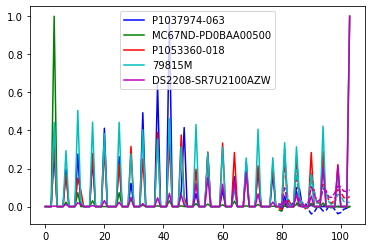

In [12]:
import matplotlib.colors as mcolors
colors = iter(mcolors.BASE_COLORS)
for p in range(tensor.shape[1]):
    color = next(colors)
    actual = tensor[predict_start:,p]
    plt.plot(range(len(actual)), actual, label=parts[p], color=color)
    pred = [qty[p] for qty in predict]
    plt.plot(range(len(x), len(x) + len(pred)), pred, color=color, linestyle='--')

plt.legend()
plt.show()

In [13]:
my_predict = [qty.tolist() for qty in predict]
my_predict
 


[[0.0167801845818758,
  -0.018392415717244148,
  -0.011082193814218044,
  0.0062217917293310165,
  0.010274273343384266],
 [-0.022153951227664948,
  -0.023674961179494858,
  -0.014326522126793861,
  0.015559013932943344,
  0.012989962473511696],
 [0.017138997092843056,
  0.01725180633366108,
  0.25275444984436035,
  0.3005260229110718,
  0.09847509860992432],
 [-0.008198476396501064,
  0.04050225019454956,
  0.04807861149311066,
  0.03152477368712425,
  0.017928238958120346],
 [0.005105283576995134,
  0.0061731114983558655,
  0.014266638085246086,
  0.004156913608312607,
  0.0025277044624090195],
 [0.02125328779220581,
  -0.003021063283085823,
  0.007405631244182587,
  0.00808519497513771,
  0.001150311902165413],
 [0.07892820984125137,
  0.0189629215747118,
  0.16610658168792725,
  0.192484512925148,
  0.06010795384645462],
 [0.003139292122796178,
  0.012645343318581581,
  0.053769953548908234,
  0.045746881514787674,
  0.035459328442811966],
 [0.017849355936050415,
  0.00440400466322